# Quickstart

### Packages

Install additional packages required to run this vignette.

In [1]:
import sys
!{sys.executable} -m pip install --quiet decoupler liana requests ipywidgets

In [2]:
import os
from pathlib import Path

import scanpy as sc
import pandas as pd
import numpy as np
import plotnine as pn
import decoupler as dc
from liana.resource import translate_column, get_hcop_orthologs

import partipy as pt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Data

First, we need to download some single-cell data. Here, we will use mouse hepatocyte profiles by scRNA-seq from [1]. In this study, the authors found that approximately 50% of liver genes exhibit significant zonation, including non-monotonic expression patterns that peak in mid-lobule layers.  

**References**  
[1] Halpern, K. B. et al. Single-cell spatial reconstruction reveals global division of labour in the mammalian liver. *Nature* **542**, 352–356 (2017).

In [3]:
def download_file(url, output_dir, use_cache=True):
    import requests
    filename = output_dir / os.path.basename(url)
    
    if use_cache and filename.exists():
        print(f"File already exists, skipping: {filename}")
        return filename

    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    with open(filename, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    
    print(f"Downloaded: {filename}")
    return filename

data_dir = Path(".") / "data"
data_dir.mkdir(exist_ok=True)

file_urls = [
    "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE84nnn/GSE84498/suppl/GSE84498%5Fexperimental%5Fdesign.txt.gz",
    "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE84nnn/GSE84498/suppl/GSE84498%5Fumitab.txt.gz"
]

for url in file_urls:
    download_file(url=url, output_dir=data_dir)

File already exists, skipping: data/GSE84498%5Fexperimental%5Fdesign.txt.gz
File already exists, skipping: data/GSE84498%5Fumitab.txt.gz


In [4]:
obs = (pd.read_csv(data_dir / os.path.basename(file_urls[0]), sep="\t")
       .set_index("well"))
count_df = (pd.read_csv(data_dir / os.path.basename(file_urls[1]), sep="\t")
            .set_index("gene").T
            .loc[obs.index, :])
adata = sc.AnnData(
    X = count_df.values.astype(np.float32),
    obs = obs, 
    var = pd.DataFrame(index=[c.split(";")[0] for c in count_df.columns])
)
adata = adata[:, adata.X.sum(axis=0) >= 20].copy()
# remove batches of different cells (probably non-hepatocytes)
adata = adata[~adata.obs["batch"].isin(["AB630", "AB631"])].copy()
adata

AnnData object with n_obs × n_vars = 1534 × 10400
    obs: 'batch', 'seq_batch_ID', 'plate_coordinates', 'pool_barcode', 'cell_barcode', 'plate', 'subject'

### Preprocessing

Before conducting archetypal analysis (AA) on single-cell RNA-seq data, it is benefical to reduce the dimensionality of the data. To achieve this, we first scale the counts across all cells to a common value, followed by log normalization. Next, we identify highly variable genes and then apply principal component analysis using only those highly variable genes. We use `scanpy` for all these steps.

... storing 'batch' as categorical
... storing 'seq_batch_ID' as categorical
... storing 'plate_coordinates' as categorical
... storing 'pool_barcode' as categorical
... storing 'cell_barcode' as categorical


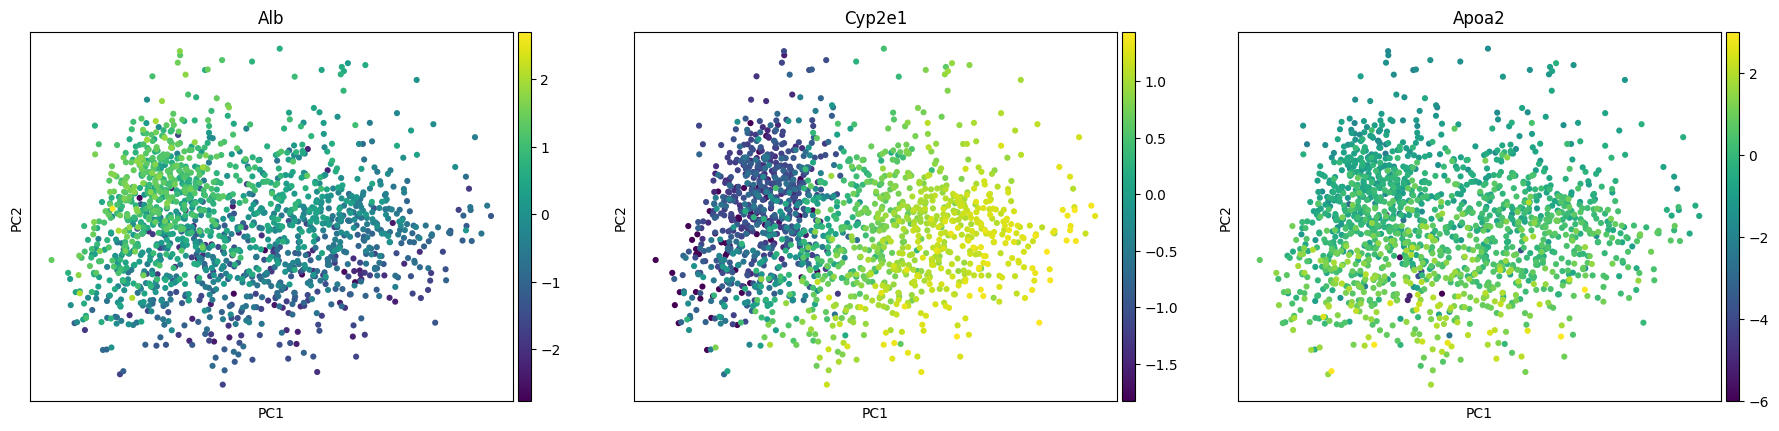

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata, mask_var="highly_variable")
adata.layers["z_scaled"]= sc.pp.scale(adata.X, max_value=10) # save this for later
sc.pl.pca_scatter(adata, color=["Alb", "Cyp2e1", "Apoa2"])

To determine the number of principal components to use for fitting the archetypes, we will examine the scree plot from the PCA. The plot indicates that the gain in explained variance becomes negligible beyond the sixth principal component.

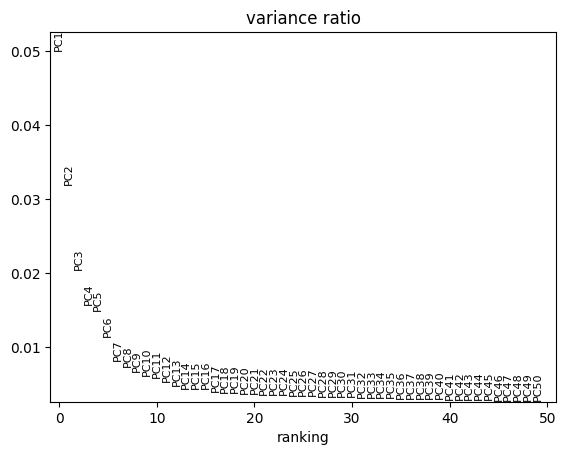

In [6]:
sc.pl.pca_variance_ratio(adata, n_pcs=50)

We store this setting in the adata.uns slot using the utility function `set_dimension`.

In [7]:
pt.set_dimension_aa(adata=adata, n_pcs=6)

### Choosing the Number of Archetypes

Now, we are ready to perform archetypal analysis, but the key question remains: how many archetypes should be used?

There is no definitive ground truth for this choice, but several heuristics can guide the decision. One approach is to evaluate how much variance is explained by different numbers of archetypes.

The function `var_explained_aa()` takes the reduced PCA data and computes the explained variance across a range of archetypes (from `min_a` to `max_a`). By default, this function utilizes all available CPU cores, as indicated by the `n_jobs` argument, which is set to `-1`.

The results are stored in `adata.uns["AA_var"]` and can be effectively visualized using plot_var_explained_aa(). The plot suggests that a reasonable choice for the number of archetypes is 3, 4, 5, or 6, as the additional explained variance becomes negligible beyond this point.

For this analysis, we will proceed with 3 archetypes.

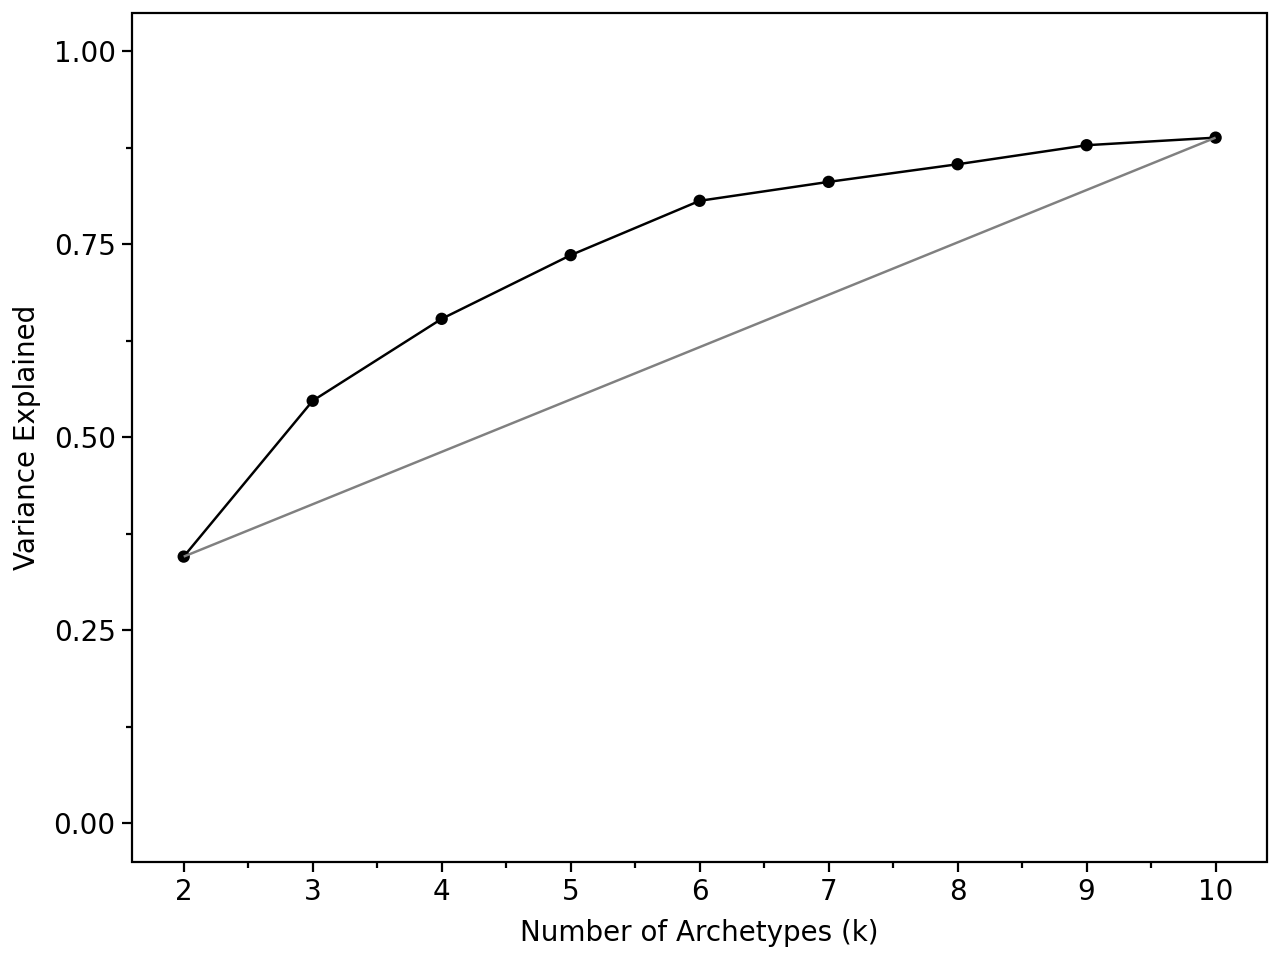

In [8]:
pt.var_explained_aa(adata=adata, min_a=2, max_a=10)
pt.plot_var_explained(adata)

An important consideration is whether the positions of the archetypes remain stable for a given number of archetypes. To assess this, we apply bootstrapping and perform Archetypal Analysis (AA) on resampled datasets.

By default, this function utilizes all available CPU cores, as specified by the `n_jobs` argument, which is set to `-1`. The results are stored in `adata.uns["AA_bootstrap"]` and can be visualized using `pt.plot_bootstrap_2D(adata)` for the first two principal components and `pt.plot_bootstrap_3D(adata)` for the first three.

Since Plotly does not render properly when exporting Jupyter notebooks, we will use only the 2D scatter plot here.

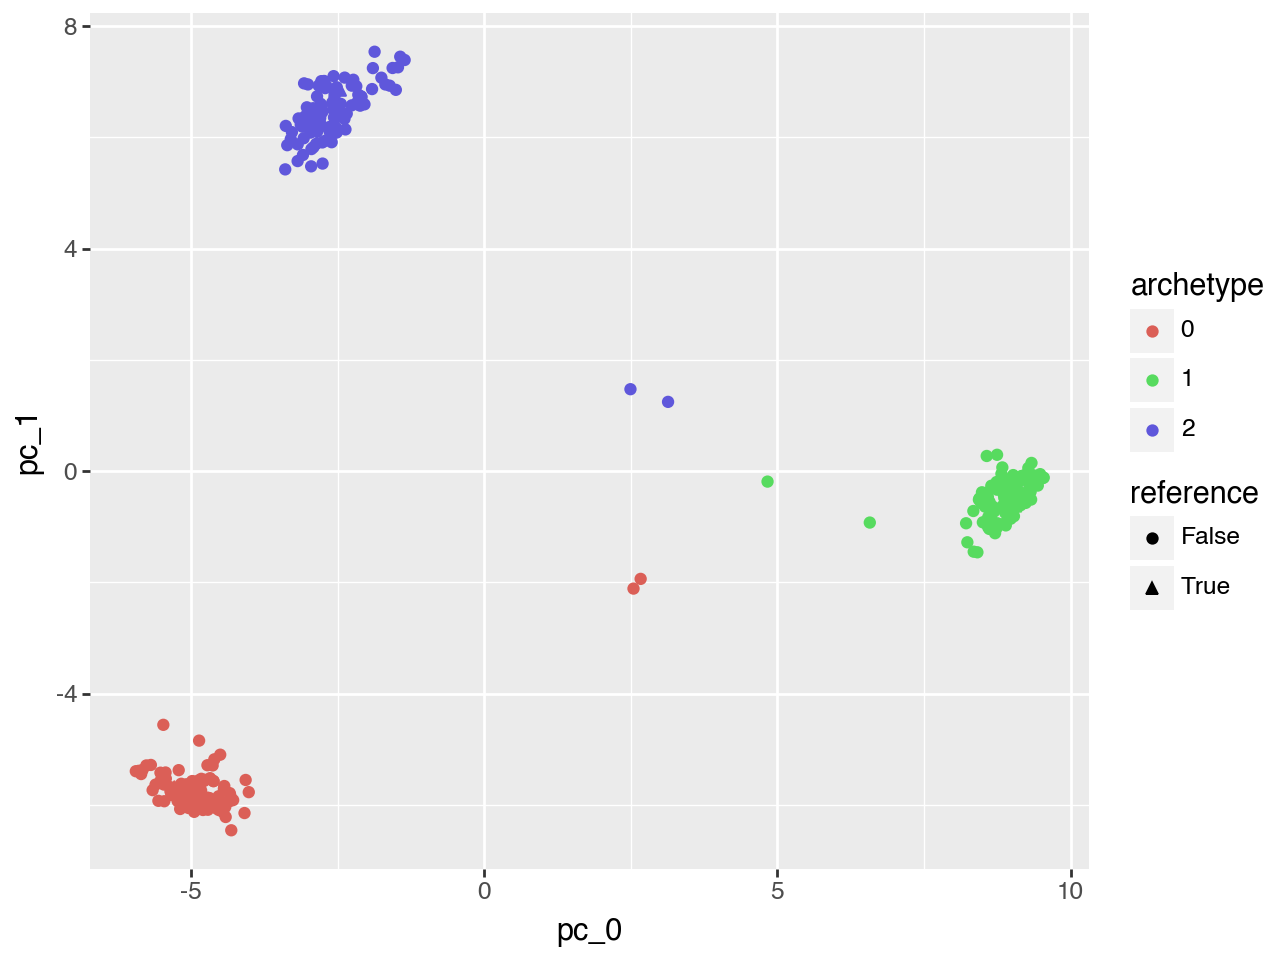

In [9]:
pt.bootstrap_aa(adata=adata, n_bootstrap=100, n_archetypes=3)

#pt.plot_bootstrap_3D(adata)
pt.plot_bootstrap_2D(adata)

### Archetypal Analysis

To compute the archetypes, we can simply use the `compute_AA` function. There are many optimization parameters which we describe in more detail in the vignette TODO.

To get a feeling for the archetypes we might plot the 

Algorithm converged after 94 iterations.


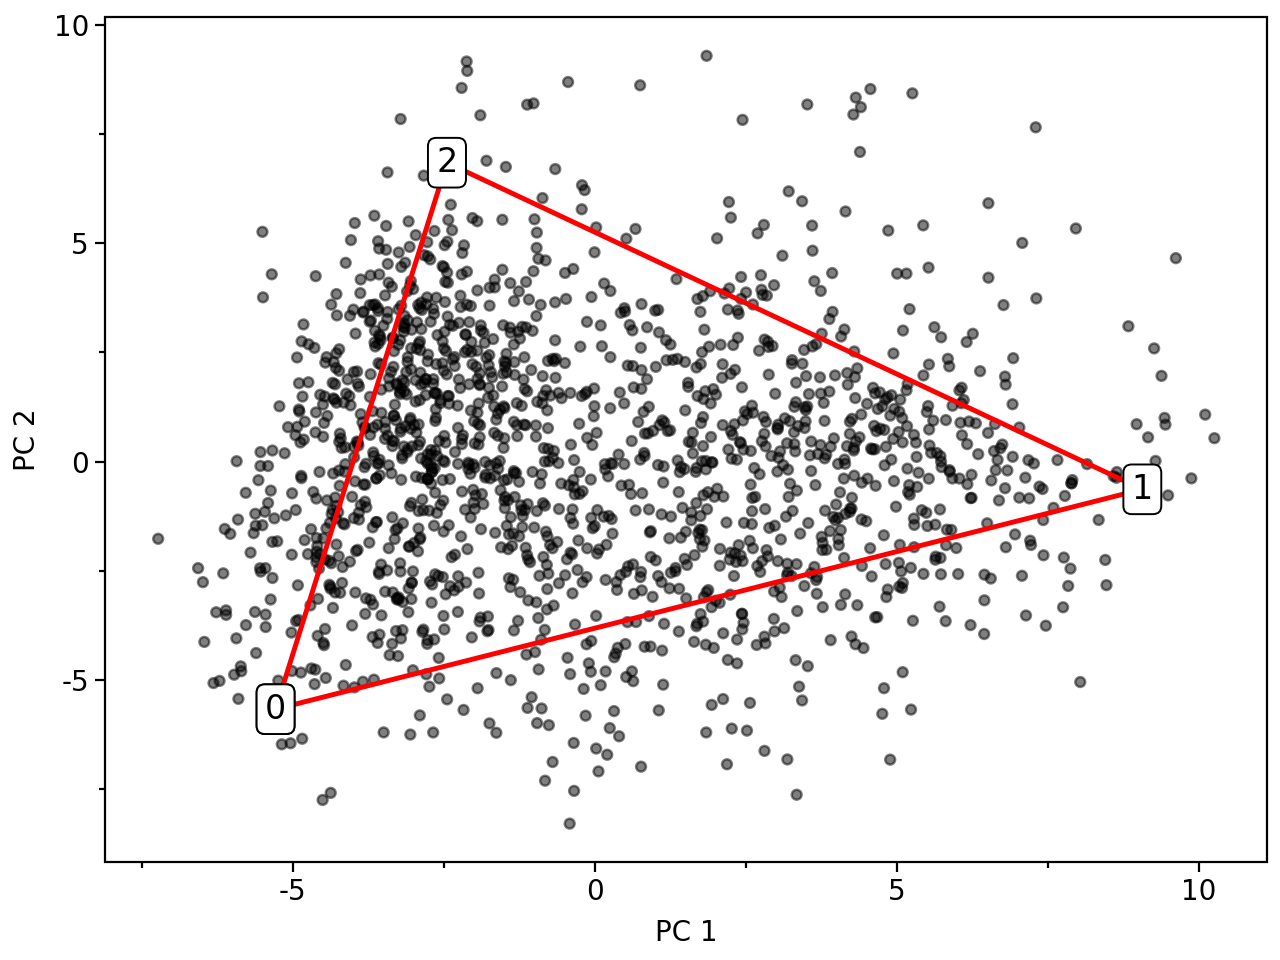

In [10]:
pt.compute_archetypes(adata, n_archetypes=3, init="furthest_sum", verbose=True)
pt.plot_archetypes_2D(adata=adata)

To better understand the archetypes, we aim to obtain the characteristic gene expression profile for each one.

We begin by computing the archetypal weights using the `calculate_weights()` function, which assigns each cell a weight for each archetype based on its proximity to the archetype in the reduced space.

Next, we generate a pseudobulk expression profile for each archetype using weighted averaging. This is achieved with the `weighted_expr()` function, which aggregates expression data across cells according to their archetypal contributions.

To better illustrate this, we visualize the weights for archetype 4 using the `plot_2D_adata()` function, highlighting the extent to which each cell is associated with it.

Applied length scale is 3.8760384777216004.


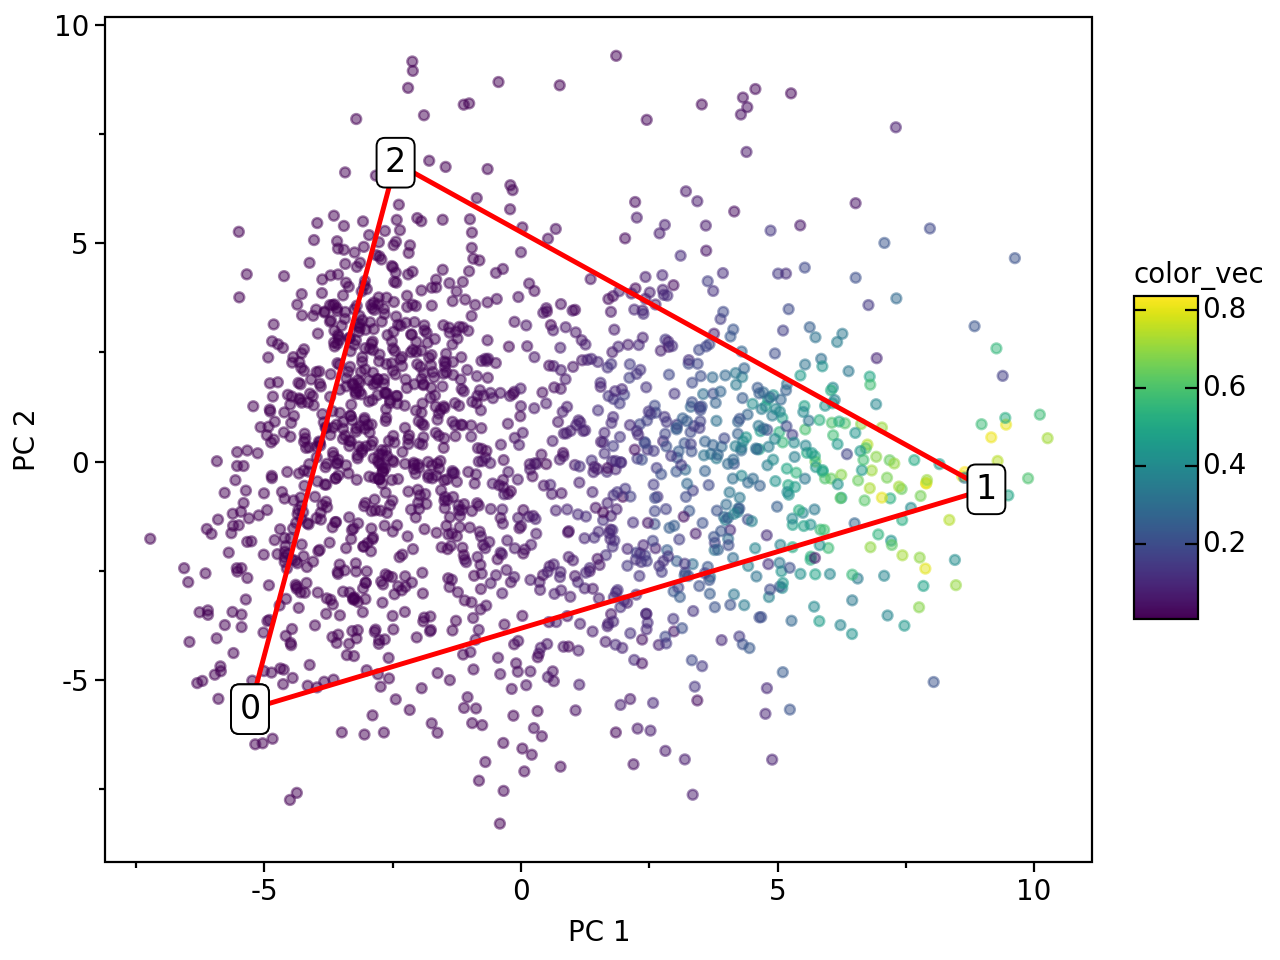

In [11]:
pt.compute_archetype_weights(X=adata, mode="automatic")
pseudobulk = pt.compute_archetype_expression(adata=adata, layer="z_scaled")

arch_idx = 1
adata.obs[f"weights_archetype_{arch_idx}"] = adata.obsm["cell_weights"][:, arch_idx]
pt.plot_archetypes_2D(adata=adata, color=f"weights_archetype_{arch_idx}")

Now we can use the characteristic gene expression profile to see which genes are relatively important for each archetype. Here we will focus on archetype 3.

This reveals many Cytochrome P450 enzymes, as well as genes involved in amino-acid metabolism such as Oat (Ornithine aminotransferase)

In [12]:
pseudobulk.T.sort_values(arch_idx, ascending=False).head(10)

,0,1,2
Cyp2a5,-0.518678,1.242558,-0.459828
Oat,-0.411625,1.159780,-0.416539
Cyp2c29,-0.606009,1.140706,-0.477760
Cyp1a2,-0.535466,1.086512,-0.568554
Lect2,-0.391595,1.078270,-0.493382
Cyp2e1,-0.475594,1.044882,-0.640528
Aldh3a2,-0.431899,1.007205,-0.551989
Gulo,-0.412959,0.987054,-0.360556
Rdh1,-0.333049,0.971324,-0.327617
Lhpp,-0.279771,0.960686,-0.320390


We can also use the characteristic gene expression profiles of each archetype to perform enrichment analysis with decoupler. Here, we focus on GO Biological Process (GO BP) terms.

Since our dataset contains mouse genes, we first translate human gene symbols to their mouse equivalents using liana.

In [13]:
map_df = get_hcop_orthologs(url="https://ftp.ebi.ac.uk/pub/databases/genenames/hcop/human_mouse_hcop_fifteen_column.txt.gz")
map_df = map_df.rename(columns={"human_symbol": "source", "mouse_symbol": "target"})
map_df = map_df[["source", "target"]]

msigdb_raw = dc.get_resource("MSigDB")
msigdb = msigdb_raw[msigdb_raw["collection"]=="go_biological_process"]
msigdb = msigdb[~msigdb.duplicated(["geneset", "genesymbol"])]
msigdb_mouse = translate_column(resource=msigdb, 
                                map_df=map_df,
                                column="genesymbol")
msigdb_mouse = msigdb_mouse.drop_duplicates()

# check how many genes from the gene set are in our andata object
pk_genes_in_adata = (msigdb_mouse[["genesymbol"]]
                     .drop_duplicates()
                     .loc[:, "genesymbol"]
                     .isin(adata.var.index.to_list())
                     .mean())
print(f"{pk_genes_in_adata=}")

acts_ulm_est, acts_ulm_est_p = dc.run_ulm(mat = pseudobulk,
                                          net = msigdb_mouse,
                                          weight = None,
                                          source="geneset",
                                          target="genesymbol",
                                          verbose = True)

acts_ulm_est.iloc[:4, :4]

/Users/pschafer/miniforge3/envs/partipy/lib/python3.11/site-packages/liana/resource/_orthology.py:199: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


pk_genes_in_adata=np.float64(0.5118753432180121)
12 features of mat are empty, they will be removed.
Running ulm on mat with 3 samples and 10388 targets for 5769 sources.


,GOBP_10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS,GOBP_2FE_2S_CLUSTER_ASSEMBLY,GOBP_2_OXOGLUTARATE_METABOLIC_PROCESS,GOBP_3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_METABOLIC_PROCESS
0,0.882099,0.323464,-3.410778,-1.230908
1,-1.403143,0.383978,2.422314,0.721435
2,1.528907,0.118265,2.191707,1.585709


We can then extract the top $x$ (here $x=25$) processes per archetype using `extract_enriched_processes()`. 

Focusing on Archetype 3 this reveals...

In [14]:
top_processes = pt.extract_enriched_processes(est=acts_ulm_est, 
                                              pval=acts_ulm_est_p, 
                                              order="desc", 
                                              n=25, 
                                              p_threshold=0.05)

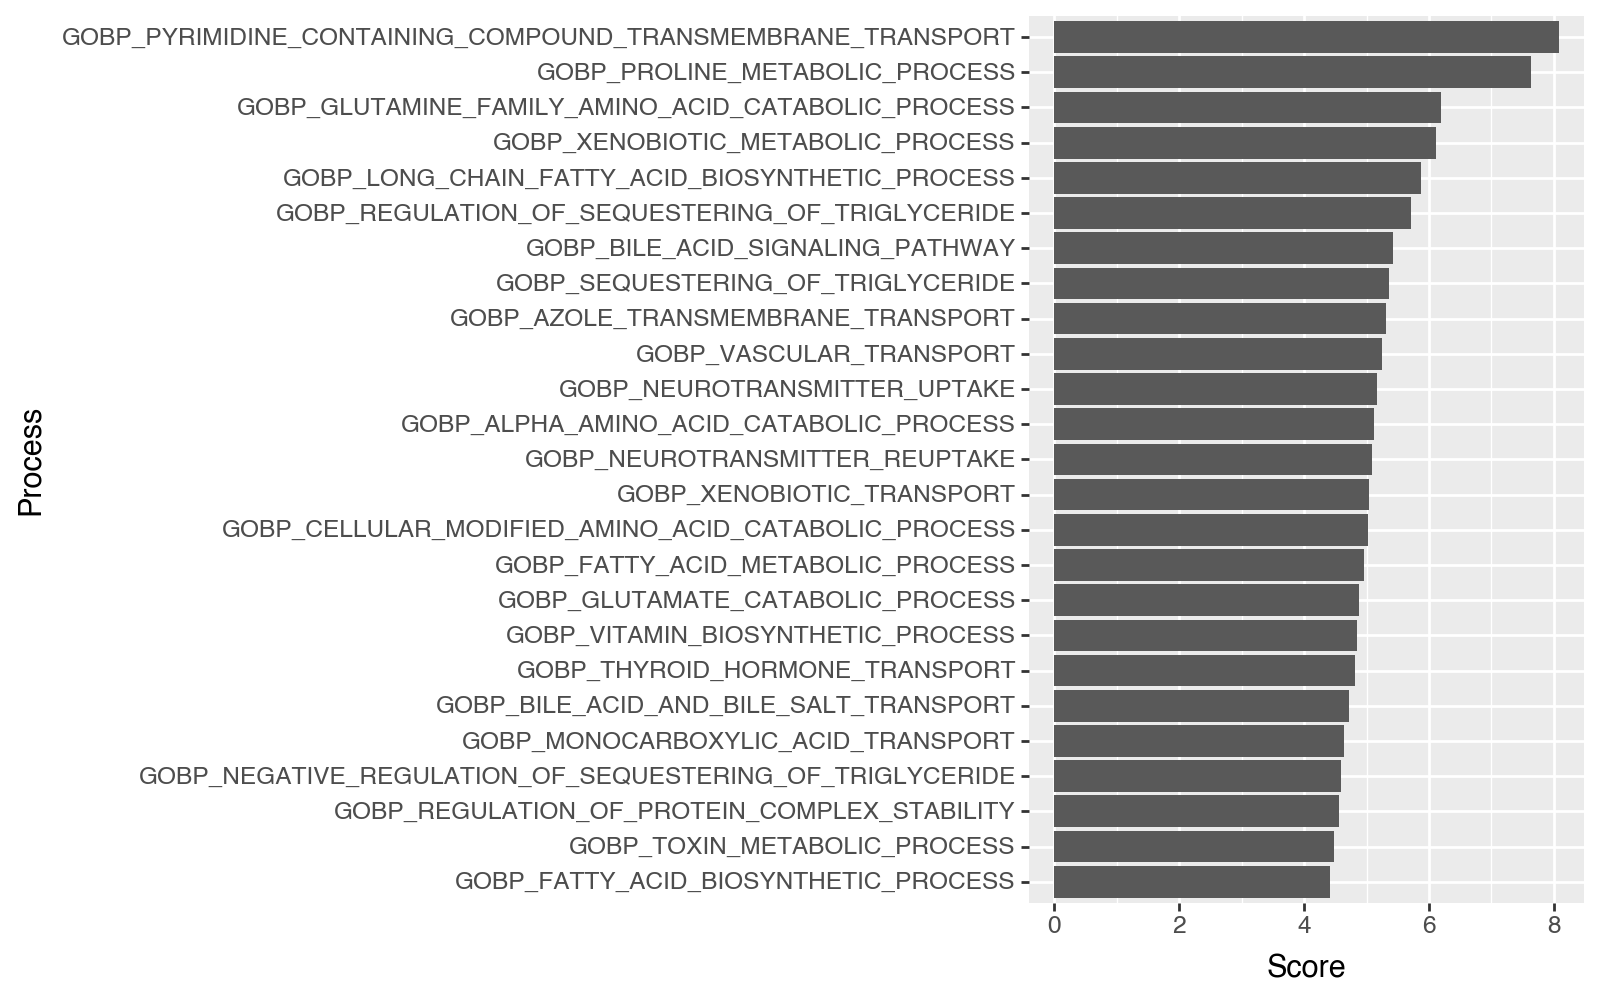

In [15]:
top_processes[f"archetype_{arch_idx}"]["Process"] = pd.Categorical(
    top_processes[f"archetype_{arch_idx}"]["Process"],
    categories=top_processes[f"archetype_{arch_idx}"].sort_values("Score", ascending=True)["Process"].to_list()
)

(pn.ggplot(top_processes[f"archetype_{arch_idx}"])
 + pn.geom_col(pn.aes(x="Process", y="Score"))
 + pn.coord_flip()
 + pn.theme(figure_size=(8, 5)))